In [1]:
import findspark

findspark.init()

In [2]:
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Import, analyse and prepare data

## Store Data

In [3]:
stores = spark.read.format("csv").option("header", "true").load("data/stores.csv")

In [4]:
stores.show()

+-----+----+------+
|Store|Type|  Size|
+-----+----+------+
|    1|   A|151315|
|    2|   A|202307|
|    3|   B| 37392|
|    4|   A|205863|
|    5|   B| 34875|
|    6|   A|202505|
|    7|   B| 70713|
|    8|   A|155078|
|    9|   B|125833|
|   10|   B|126512|
|   11|   A|207499|
|   12|   B|112238|
|   13|   A|219622|
|   14|   A|200898|
|   15|   B|123737|
|   16|   B| 57197|
|   17|   B| 93188|
|   18|   B|120653|
|   19|   A|203819|
|   20|   A|203742|
+-----+----+------+
only showing top 20 rows



As I want to make predictions per store, the store data itself is not relevant for my model

## Feature Data

In [5]:
features = spark.read.format("csv").option("header", "true").load("data/features.csv")

In [6]:
features.show()

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|05/02/2010|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    FALSE|
|    1|12/02/2010|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     TRUE|
|    1|19/02/2010|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    FALSE|
|    1|26/02/2010|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|    FALSE|
|    1|05/03/2010|       46.5|     2.625|       NA|       NA|       NA|       NA|       NA|211.3501429|       8

In [7]:
features.printSchema()

root
 |-- Store: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Fuel_Price: string (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: string (nullable = true)



The data has to be transformed into the correct datatypes.

As MarkDown data is not available for more than half of the records, I decided to neglect this information for the model.

In [8]:
from pyspark.sql.types import DoubleType, IntegerType, DateType, BooleanType
from pyspark.sql.functions import to_date


features = features\
    .withColumn("Store", features.Store.cast(IntegerType()))\
    .withColumn("Date", to_date(features.Date, "dd/MM/yyyy"))\
    .withColumn("Temperature", features.Temperature.cast(DoubleType()))\
    .withColumn("Fuel_Price", features.Fuel_Price.cast(DoubleType()))\
    .withColumn("CPI", features.CPI.cast(DoubleType()))\
    .withColumn("Unemployment", features.Unemployment.cast(DoubleType()))\
    .withColumn("IsHoliday", features.IsHoliday.cast(BooleanType()))

features = features.select("Store",\
                           "Date",\
                           "Temperature",\
                           "Fuel_Price",\
                           "CPI",\
                           "Unemployment",\
                           "IsHoliday")

In [9]:
features.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)



In [10]:
features.show()

+-----+----------+-----------+----------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+-----------+------------+---------+
|    1|2010-02-05|      42.31|     2.572|211.0963582|       8.106|    false|
|    1|2010-02-12|      38.51|     2.548|211.2421698|       8.106|     true|
|    1|2010-02-19|      39.93|     2.514|211.2891429|       8.106|    false|
|    1|2010-02-26|      46.63|     2.561|211.3196429|       8.106|    false|
|    1|2010-03-05|       46.5|     2.625|211.3501429|       8.106|    false|
|    1|2010-03-12|      57.79|     2.667|211.3806429|       8.106|    false|
|    1|2010-03-19|      54.58|      2.72| 211.215635|       8.106|    false|
|    1|2010-03-26|      51.45|     2.732|211.0180424|       8.106|    false|
|    1|2010-04-02|      62.27|     2.719|210.8204499|       7.808|    false|
|    1|2010-04-09|      65.86|      2.77|210.6228574|       7.808|    false|

## Sales Data

In [11]:
sales = spark.read.format("csv").option("header", "true").load("data/sales.csv")

In [12]:
sales.show()

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|05/02/2010|     24924.5|    FALSE|
|    1|   1|12/02/2010|    46039.49|     TRUE|
|    1|   1|19/02/2010|    41595.55|    FALSE|
|    1|   1|26/02/2010|    19403.54|    FALSE|
|    1|   1|05/03/2010|     21827.9|    FALSE|
|    1|   1|12/03/2010|    21043.39|    FALSE|
|    1|   1|19/03/2010|    22136.64|    FALSE|
|    1|   1|26/03/2010|    26229.21|    FALSE|
|    1|   1|02/04/2010|    57258.43|    FALSE|
|    1|   1|09/04/2010|    42960.91|    FALSE|
|    1|   1|16/04/2010|    17596.96|    FALSE|
|    1|   1|23/04/2010|    16145.35|    FALSE|
|    1|   1|30/04/2010|    16555.11|    FALSE|
|    1|   1|07/05/2010|    17413.94|    FALSE|
|    1|   1|14/05/2010|    18926.74|    FALSE|
|    1|   1|21/05/2010|    14773.04|    FALSE|
|    1|   1|28/05/2010|    15580.43|    FALSE|
|    1|   1|04/06/2010|    17558.09|    FALSE|
|    1|   1|1

In [13]:
sales.printSchema()

root
 |-- Store: string (nullable = true)
 |-- Dept: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: string (nullable = true)
 |-- IsHoliday: string (nullable = true)



The data has to be transformed into the correct datatypes.


In [14]:
sales = sales\
    .withColumn("Store", sales.Store.cast(IntegerType()))\
    .withColumn("Dept", sales.Dept.cast(IntegerType()))\
    .withColumn("Date", to_date(sales.Date, "dd/MM/yyyy"))\
    .withColumn("Weekly_Sales", sales.Weekly_Sales.cast(DoubleType()))\
    .withColumn("IsHoliday", sales.IsHoliday.cast(BooleanType()))

In [15]:
sales.show()

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    false|
|    1|   1|2010-02-12|    46039.49|     true|
|    1|   1|2010-02-19|    41595.55|    false|
|    1|   1|2010-02-26|    19403.54|    false|
|    1|   1|2010-03-05|     21827.9|    false|
|    1|   1|2010-03-12|    21043.39|    false|
|    1|   1|2010-03-19|    22136.64|    false|
|    1|   1|2010-03-26|    26229.21|    false|
|    1|   1|2010-04-02|    57258.43|    false|
|    1|   1|2010-04-09|    42960.91|    false|
|    1|   1|2010-04-16|    17596.96|    false|
|    1|   1|2010-04-23|    16145.35|    false|
|    1|   1|2010-04-30|    16555.11|    false|
|    1|   1|2010-05-07|    17413.94|    false|
|    1|   1|2010-05-14|    18926.74|    false|
|    1|   1|2010-05-21|    14773.04|    false|
|    1|   1|2010-05-28|    15580.43|    false|
|    1|   1|2010-06-04|    17558.09|    false|
|    1|   1|2

In [16]:
sales.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)



# Data Statistics

In [17]:
sales.describe().show()

+-------+------------------+------------------+------------------+
|summary|             Store|              Dept|      Weekly_Sales|
+-------+------------------+------------------+------------------+
|  count|            421570|            421570|            421570|
|   mean|22.200545579619043| 44.26031738501317|15981.258123467534|
| stddev| 12.78529738990308|30.492054015786014|22711.183519163187|
|    min|                 1|                 1|          -4988.94|
|    max|                45|                99|         693099.36|
+-------+------------------+------------------+------------------+



In [18]:
features.describe().show()

+-------+---------------+-----------------+-------------------+------------------+-----------------+
|summary|          Store|      Temperature|         Fuel_Price|               CPI|     Unemployment|
+-------+---------------+-----------------+-------------------+------------------+-----------------+
|  count|           8190|             8190|               8190|              7605|             7605|
|   mean|           23.0|59.35619780219781| 3.4059918192918217|172.46080918276078|7.826821038790305|
| stddev|12.987966099514| 18.6786068489072|0.43133657110071383| 39.73834609860842|1.877258593917429|
|    min|              1|            -7.29|              2.472|           126.064|            3.684|
|    max|             45|           101.95|              4.468|       228.9764563|           14.313|
+-------+---------------+-----------------+-------------------+------------------+-----------------+



# Join Data

In [19]:
df = sales.join(features, ["Store", "Date", "IsHoliday"])
df.show()

+-----+----------+---------+----+------------+-----------+----------+-----------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|        CPI|Unemployment|
+-----+----------+---------+----+------------+-----------+----------+-----------+------------+
|    1|2010-02-05|    false|   1|     24924.5|      42.31|     2.572|211.0963582|       8.106|
|    1|2010-02-12|     true|   1|    46039.49|      38.51|     2.548|211.2421698|       8.106|
|    1|2010-02-19|    false|   1|    41595.55|      39.93|     2.514|211.2891429|       8.106|
|    1|2010-02-26|    false|   1|    19403.54|      46.63|     2.561|211.3196429|       8.106|
|    1|2010-03-05|    false|   1|     21827.9|       46.5|     2.625|211.3501429|       8.106|
|    1|2010-03-12|    false|   1|    21043.39|      57.79|     2.667|211.3806429|       8.106|
|    1|2010-03-19|    false|   1|    22136.64|      54.58|      2.72| 211.215635|       8.106|
|    1|2010-03-26|    false|   1|    26229.21|    

In [20]:
df.orderBy('Date').tail(1)

[Row(Store=45, Date=datetime.date(2012, 10, 26), IsHoliday=False, Dept=98, Weekly_Sales=1076.8, Temperature=58.85, Fuel_Price=3.882, CPI=192.3088989, Unemployment=8.667)]

Note: The data ranges from 2010-02-05 (week 5) until 2012-10-26 (week 43 )

# Define Features/Categories

In [21]:
from pyspark.sql.functions import weekofyear, year


df = df.withColumn('Week', weekofyear(df.Date))
df = df.withColumn('Year', year(df.Date))
df = df.withColumn('IsHoliday', df.IsHoliday.cast(IntegerType()))
df.show()

+-----+----------+---------+----+------------+-----------+----------+-----------+------------+----+----+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|        CPI|Unemployment|Week|Year|
+-----+----------+---------+----+------------+-----------+----------+-----------+------------+----+----+
|    1|2010-02-05|        0|   1|     24924.5|      42.31|     2.572|211.0963582|       8.106|   5|2010|
|    1|2010-02-12|        1|   1|    46039.49|      38.51|     2.548|211.2421698|       8.106|   6|2010|
|    1|2010-02-19|        0|   1|    41595.55|      39.93|     2.514|211.2891429|       8.106|   7|2010|
|    1|2010-02-26|        0|   1|    19403.54|      46.63|     2.561|211.3196429|       8.106|   8|2010|
|    1|2010-03-05|        0|   1|     21827.9|       46.5|     2.625|211.3501429|       8.106|   9|2010|
|    1|2010-03-12|        0|   1|    21043.39|      57.79|     2.667|211.3806429|       8.106|  10|2010|
|    1|2010-03-19|        0|   1|    22136.64|      54.

In [22]:
df.count()

421570

In [37]:
# check for null entries by comparing count with null rows removed
df.na.drop().count()

421570

In [24]:
df_pd = df.toPandas()

In [25]:
df_pd

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Week,Year
0,1,2010-02-05,0,1,24924.50,42.31,2.572,211.096358,8.106,5,2010
1,1,2010-02-12,1,1,46039.49,38.51,2.548,211.242170,8.106,6,2010
2,1,2010-02-19,0,1,41595.55,39.93,2.514,211.289143,8.106,7,2010
3,1,2010-02-26,0,1,19403.54,46.63,2.561,211.319643,8.106,8,2010
4,1,2010-03-05,0,1,21827.90,46.50,2.625,211.350143,8.106,9,2010
...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2012-09-28,0,98,508.37,64.88,3.997,192.013558,8.684,39,2012
421566,45,2012-10-05,0,98,628.10,64.89,3.985,192.170412,8.667,40,2012
421567,45,2012-10-12,0,98,1061.02,54.47,4.000,192.327265,8.667,41,2012
421568,45,2012-10-19,0,98,760.01,56.47,3.969,192.330854,8.667,42,2012


In [26]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters


register_matplotlib_converters()

df_grouped =df_pd.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
plt.figure(figsize=(12,4))
plt.plot(df_grouped['Date'], df_grouped['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')

Text(0, 0.5, 'Weekly_Sales')

There are obvious peaks/trends in the weekly sales during the holidays at the end of 2010 and 2011.

In [27]:
df_group_all =df_pd.groupby(by=['Date'], as_index=False)['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'].sum()


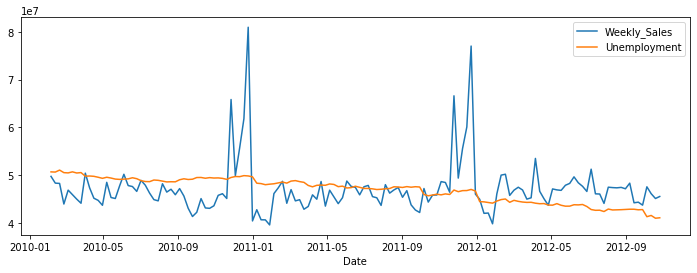

In [28]:
df_group_all['Unemployment'] = df_group_all['Unemployment']*2000

plt.figure(figsize=(12,4))
plt.plot(df_group_all['Date'], df_group_all['Weekly_Sales'])
plt.plot(df_group_all['Date'], df_group_all['Unemployment'])
plt.xlabel('Date')
plt.legend(('Weekly_Sales', 'Unemployment'))
plt.savefig('unemployment.png')

The graph shows that there is no correlation between weekly sales and unemployment.

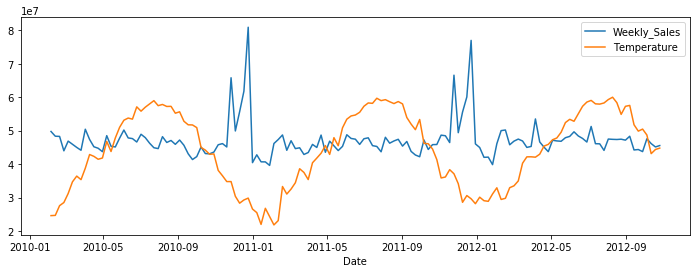

In [29]:
df_group_all['Temperature'] = df_group_all['Temperature']*250

plt.figure(figsize=(12,4))
plt.plot(df_group_all['Date'], df_group_all['Weekly_Sales'])
plt.plot(df_group_all['Date'], df_group_all['Temperature'])
plt.xlabel('Date')
plt.legend(('Weekly_Sales', 'Temperature'))

The graph shows that there is no direct correlation between temperature and sales. Nevertheless, theres is some kind of repetitive pattern with the same frequency. This supports the assumption that there is some kind of seasonal trend, as temperatures change according to the season.

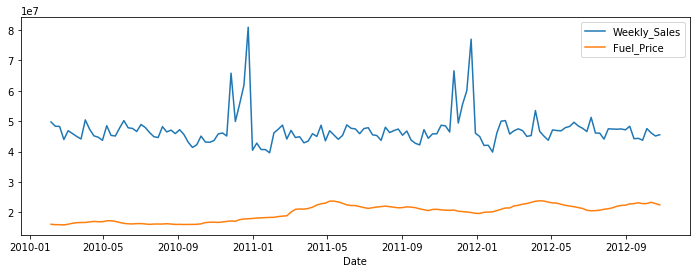

In [30]:
df_group_all['Fuel_Price'] = df_group_all['Fuel_Price']*2000

plt.figure(figsize=(12,4))
plt.plot(df_group_all['Date'], df_group_all['Weekly_Sales'])
plt.plot(df_group_all['Date'], df_group_all['Fuel_Price'])
plt.xlabel('Date')
plt.legend(('Weekly_Sales', 'Fuel_Price'))

The graph shows that there is no correlation between weekly sales and fuel price.

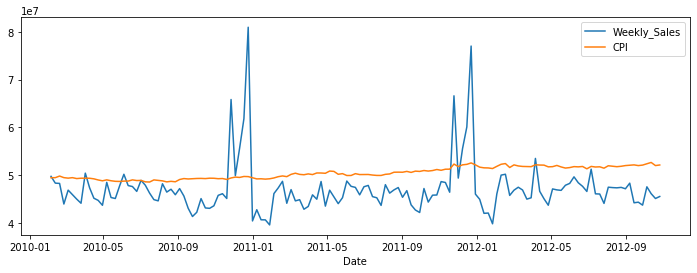

In [31]:
df_group_all['CPI'] = df_group_all['CPI']*100

plt.figure(figsize=(12,4))
plt.plot(df_group_all['Date'], df_group_all['Weekly_Sales'])
plt.plot(df_group_all['Date'], df_group_all['CPI'])
plt.xlabel('Date')
plt.legend(('Weekly_Sales', 'CPI'))

The graph shows that there is also no correlation between weekly sales and CPI.

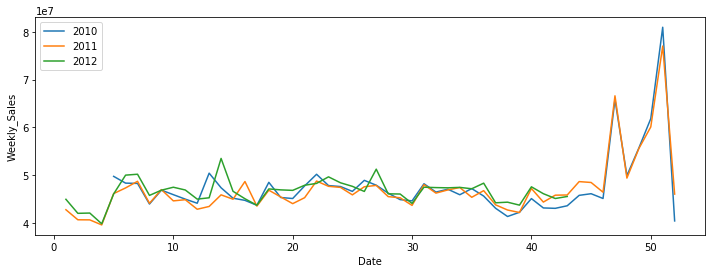

In [32]:
df_2010 = df_pd[df_pd['Year']==2010]
df_2010_grouped =df_2010.groupby(by=['Week'], as_index=False)['Weekly_Sales'].sum()

df_2011 = df_pd[df_pd['Year']==2011]
df_2011_grouped =df_2011.groupby(by=['Week'], as_index=False)['Weekly_Sales'].sum()

df_2012 = df_pd[df_pd['Year']==2012]
df_2012_grouped =df_2012.groupby(by=['Week'], as_index=False)['Weekly_Sales'].sum()

plt.figure(figsize=(12,4))
plt.plot(df_2010_grouped['Week'], df_2010_grouped['Weekly_Sales'])
plt.plot(df_2011_grouped['Week'], df_2011_grouped['Weekly_Sales'])
plt.plot(df_2012_grouped['Week'], df_2012_grouped['Weekly_Sales'])

plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.legend(('2010', '2011', '2012'))
plt.savefig('years.png')


### Conclusion
It does not make any sense to consider temperature, unemployment, CPI or fuel price as features. As illustrated in the l ast graph, there only pattern visible on first glance is a seasonal trend. Therefore, I decided to proceed with a time-series model. I chose to use Holt-Winters exponential smoothing due to the seasonal trend in the data. 

# Create and train Model

In [33]:
df_group_sales = df_pd.groupby('Date', as_index=False)['Weekly_Sales'].sum()
df_group_sales = df_group_sales.set_index("Date")

df_group_sales

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


In [34]:
split_point = 100

# take first x entries as train data
train = df_group_sales.iloc[:split_point]
# test with remaining entries
test = df_group_sales.iloc[split_point:]

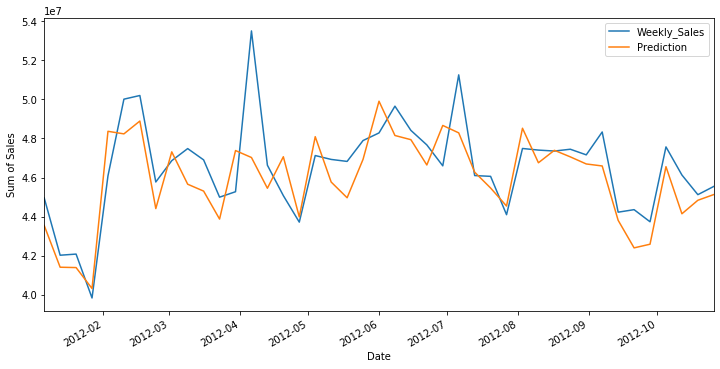

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


fit_model = ExponentialSmoothing(train,
                                  seasonal='mul',
                                  seasonal_periods=52,
                                  freq='W-FRI'
                                ).fit()
prediction = fit_model.forecast(len(df_group_sales)-split_point)
prediction


test.plot(figsize=(12,6))
prediction.plot()
plt.legend(('Weekly_Sales','Prediction'))
plt.ylabel('Sum of Sales')
plt.savefig('prediction.png')


# Evaluate Predictions

In [36]:
import numpy as np


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Mean Absolute Percentage Error = {a}%".format(a=mean_absolute_percentage_error(test['Weekly_Sales'],prediction)))

Mean Absolute Percentage Error = 2.662007651696243%


# Final Conclusions

Exponential Smoothing seems to do a pretty good job. The current ratio is 100 entries for training and 43 entries for testing. 
The mean absolute percentage error will go down if the training set is extended, i.e. taking a ratio of 130 entries for training and the remaining 13 entries for testing will result in an error of 1.48% instead of 2.66% 